In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from datetime import datetime
from heapq import heappush,heappop
from collections import Counter

PATH="/home/yui/Documents/data/recommender/ratings_Beauty.csv"

func = lambda x:datetime.utcfromtimestamp(x).\
        strftime('%Y-%m-%d %H:%M:%S')
df=pd.read_csv(PATH)
df['Date']=df['Timestamp'].apply(func)
df.head(5)

def returnSumNProductID(df):
    d = dict()
    for row in tqdm(range(df.shape[0])):
        id_ = df.iloc[row]['ProductId']
        total,n,elements = d.get(id_,(0,0,[]))
        total+=df.iloc[row]['Rating']
        n+=1
        elements.append(df.iloc[row]['Rating'])
        d[id_]=(total,n,elements)
    return d
d = returnSumNProductID(df)

100%|██████████| 2023070/2023070 [07:35<00:00, 4442.51it/s]


#### Bernoulli Distribution
$$p(x_i|\pi)=\pi^{x_i}(1-\pi)^{1-x_i}$$
where $x_i \in \{0,1\}$, $\pi$ the probability that the impression gets a click, the coin is a head, or the post gets a like.

#### Beta Distribution
$$p(\pi)=\frac{1}{B(\alpha,\beta)}\pi^{\alpha-1}(1-\pi)^{\beta-1}$$
where $\beta(\alpha,\beta)=\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$. It is a distribution of a probability.

#### Posterior = Conjugate Prior
Based on Bayes rule, $P(A|B)=\frac{P(B|A)P(A)}{P(B)}$,
$$
p(\pi|X) = \frac{p(X|\pi)p(\pi)}{\int^1_0p(X|\pi)p(\pi)d\pi}\propto p(X|\pi)p(\pi)
$$
Since our belief gets improved with more and more seen data, same as our prior will get updated. The prior should be uniform $\alpha,\beta=1,1$ with no bias, the prior will converge later as more seen data is used to update the model.

$$\begin{align*}
p(\pi|X)&\propto p(X|\pi)p(\pi) =\prod^N_{i=1}p(x_i|\pi)p(\pi) \\
&=\frac{1}{B(\alpha,\beta)}\pi^{\alpha-1}(1-\pi)^{\beta-1}\prod^N_{i=1}\pi^{x_i}(1-\pi)^{1-x_i} \\
&\propto \pi^{\alpha+\sum^N_{i=1}x_i-1}(1-\pi)^{\beta+N-\sum^N_{i=1}x_i-1}\\
&\propto \pi^{\alpha'-1}(1-\pi)^{\beta'-1}
\end{align*}$$

Therefore, the new parameters of beta distribution become, 
$$\begin{align*}
\alpha' &= \alpha + \sum^N_{i=1}x_i \\
\beta' &= \beta + N-\sum^N_{i=1}x_i
\end{align*}$$

Bayesian Approach is great because sampling automatically balances between exploration and exploitation.

#### Online Learning
1. Choose a likelihood and prior distribution.
2. Calculate the posterior. 
3. Sample a new probability from $p(\theta|X)$ for ranking.
4. Update parameters $\alpha'=\alpha+x_i \quad \beta'=\beta+1-x_i$.

In [2]:
maxVal,longestList = 0,[]
for key,val in tqdm(d.items()):
    if val[1]>maxVal:
        longestList = val[2]
        maxVal = val[1]

100%|██████████| 249274/249274 [00:00<00:00, 4611490.39it/s]


In [4]:
print(longestList[:3],maxVal)

[5.0, 5.0, 5.0] 7533


In [6]:
moreThan3 = [1 if i>3 else 0 for i in longestList]
print(moreThan3[:3])

[1, 1, 1]


In [29]:
moreThan3 = [1,0,1,1,1,0,0,0,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1]

In [30]:
from scipy.stats import beta as Beta

100%|██████████| 20/20 [00:00<00:00, 177.45it/s]


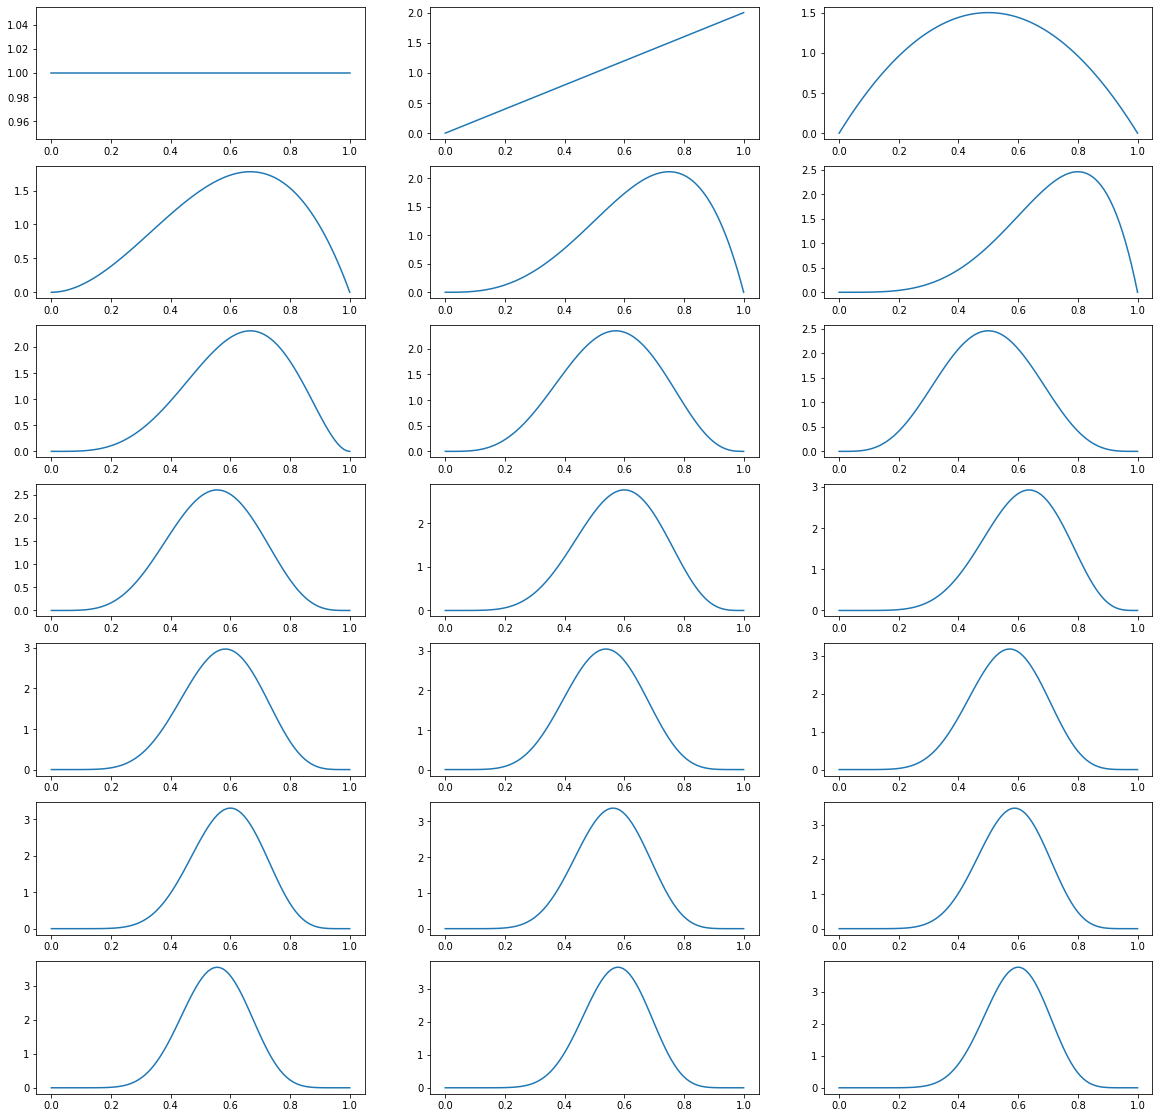

In [33]:
plt.figure(figsize=(20,20))
alpha,beta,N=1,1,20
x = np.linspace(0,1,100)
for i,n in enumerate(tqdm(moreThan3[:N])):
    ax = plt.subplot(N//3+1,3,i+1)
    plt.plot(x,Beta.pdf(x,alpha,beta))
    alpha+=n
    beta+=1-n
ax = plt.subplot(N//3+1,3,i+2)
plt.plot(x,Beta.pdf(x,alpha,beta))

#### Gaussian Conjugate Prior
This does not take precision (/variance) into account.

Likelihood
$$x_i \sim \mathcal{N}(\mu,\tau^{-1})$$
Prior
$$\mu \sim \mathcal{N}(m,\lambda^{-1})$$
Posterior update
$$m'=\frac{\lambda m+\tau\sum^N_{i=1}x_i}{\lambda+N\tau} \quad \lambda'=\lambda+N\tau$$
As N increases, $\lambda \rightarrow \infty$, $\sigma^2\rightarrow 0$.

Interesting to note that, the smoothed average looks quite like posterior mean, smoothed average,
$$r = \frac{\lambda\mu_0+\sum^N_{i=1}x_i}{\lambda+N}$$
Even for beta posterior mean, 
$$\mathbb{E}(\pi)=\frac{\alpha'}{\alpha'+\beta'}=\frac{\alpha+\sum^N_{i=1}x_i}{\alpha+\beta+N}$$